# Alignment Tutorial for SM and ST Data

The raw ST and SM data exhibit different morphologies and resolutions. After alignment with spatialMETA, the ST and SM data were successfully aligned, allowing the SM data, which lack H&E images, to be projected onto H&E images derived from the ST data

In [1]:
cd ..

/home/rolan/Documents/spatialMETA


/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import spatialmeta as smt
from spatialmeta.model import AlignmentModule
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

## Read and preprocess data

The ST and SM data are read from h5ad files using the `smt.read_h5ad_st()` and `smt.read_h5ad_sm()` functions, respectively. The ST data is then normalized and log-transformed using the `normalize_non_inplace()` function. The top spatial variable genes/metabolites are identified using the `smt.pp.spatial_variable()` function. And the test data can be available from `load_adata()`

### read data

Read raw ST and SM data in h5ad format. 

In [3]:
# If data is available
st_path = "./spatialmeta_tutorial/data/Y7_T_adata_ST_raw.h5ad"
sm_path = "./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad"
adata_st = smt.read_h5ad_st(st_path)
adata_sm = smt.read_h5ad_sm(sm_path)

In [6]:
#Test data can be obtained from SpatialMETA
adata_st = smt.data.load_adata(
    sample_name="Y7_T_raw",
    modality="ST"
)
adata_sm = smt.data.load_adata(
    sample_name="Y7_T_raw",
    modality="SM"
)

/home/rolan/Documents/spatialMETA/spatialmeta/data/./datasets/adata_SM_Y7_T_raw_raw.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77.7M  100 77.7M    0     0   274k      0  0:04:49  0:04:49 --:--:--  305k


### preprocess ST data

Normalize the ST data through the scanpy.pp.normalize_total() and scanpy.pp.log1p().

In [4]:
def normalize_non_inplace(adata):
    adata.layers['normalized'] = copy.deepcopy(adata.X)
    sc.pp.normalize_total(adata, layer='normalized')
    sc.pp.log1p(adata, layer='normalized')
normalize_non_inplace(adata_st)

Calculate the top spatial variable genes using the moranI method, which provid by the Squidpy

In [5]:
smt.pp.spatial_variable(
    adata_st,
    n_top_variable=2000,
    add_key= "highly_variable_moranI",
    layer='normalized'
)

In [6]:
adata_st = adata_st[:,adata_st.var['highly_variable_moranI']]

scale x to 0-100 and keep aspect ratio

In [7]:
xmin,xmax = adata_st.obsm['spatial'][:,0].min(), adata_st.obsm['spatial'][:,0].max()
adata_st.obsm['spatial_normalized'] = (adata_st.obsm['spatial'] - xmin) / (xmax - xmin) * 100

### preprocess SM data

Normalize the SM data through the scanpy.pp.normalize_total

In [8]:
sc.pp.normalize_total(adata_sm, target_sum=1e3)

Calculate the top spatial variable metabolites using the moranI method, which provid by the Squidpy

In [9]:
smt.pp.spatial_variable(
    adata_sm,
    n_top_variable=500,
    add_key= "highly_variable_moranI",
)

In [10]:
adata_sm = adata_sm[:,adata_sm.var['highly_variable_moranI']]

In [11]:
xmin,xmax = adata_sm.obsm['spatial'][:,0].min(), adata_sm.obsm['spatial'][:,0].max()

To ensure alignment between the SM and ST data, the SM data locations are manually adjusted. This involves rotating the SM image to match the orientation of the ST data. The `smt.pl.plot_spot_sm_st()` function is used to visualize the alignment before and after adjustment.

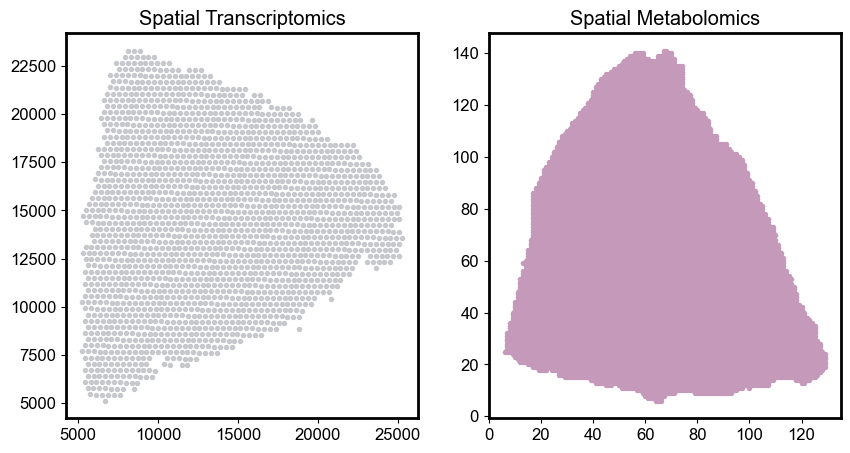

In [12]:
smt.pl.plot_spot_sm_st(adata_SM = adata_sm,
                       adata_ST = adata_st,
                       marker = 'H',
                       SM_spatial_key = "spatial")

In [13]:
smt.pp.spot_transform_by_manual(
    adata = adata_sm,
    rotation = -90,
    spatial_key_SM = "spatial",
    new_spatial_key_SM = "spatial"
)

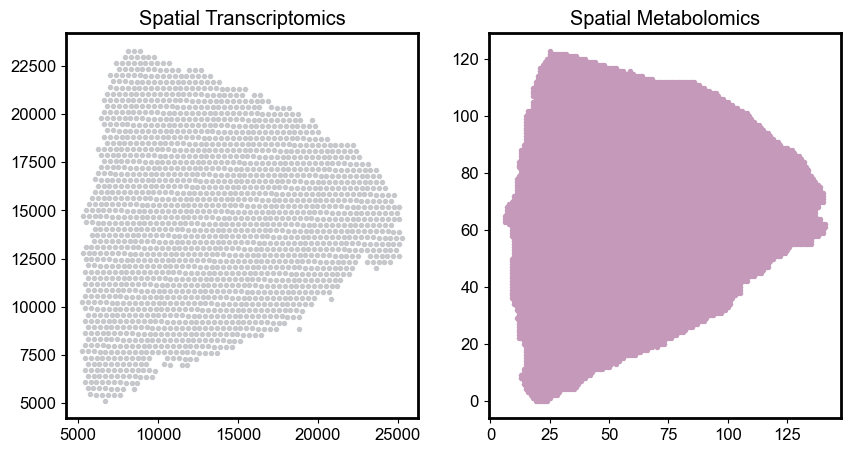

In [14]:
smt.pl.plot_spot_sm_st(adata_SM = adata_sm,
                       adata_ST = adata_st,
                       marker = 'H',
                       SM_spatial_key = "spatial")

scale x to 0-100 and keep aspect ratio

In [15]:
adata_sm.obsm['spatial_normalized'] = (adata_sm.obsm['spatial'] - xmin) / (xmax - xmin) * 100

## Alignment Model

An AlignmentModule model is created using the `AlignmentModule()` class. The model is trained using the `fit_vae()` function, which minimizes the reconstruction loss between the aligned SM and ST data.

### Create and fit the model

Create an AlignmentModule model obejct use AlignmentModule().

In [16]:
model = AlignmentModule(
    adata_st=adata_st,
    adata_sm=adata_sm,
    n_latent=10,
    device='cuda:0'
)

Now train model.

In [17]:
loss_dict = model.fit_vae(max_epoch=128)

/home/rolan/Documents/spatialMETA/spatialmeta/util/logger.py:151: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm_notebook
Epoch: 100%|██████████| 128/128 [00:29<00:00,  4.40it/s, reconst_sm=9.78e+00, reconst_st=1.89e+01, kldiv


Plot the rasterized feature map.

Latent Embedding: |          | 84/? [00:00<00:00, 878.60it/s]                                           


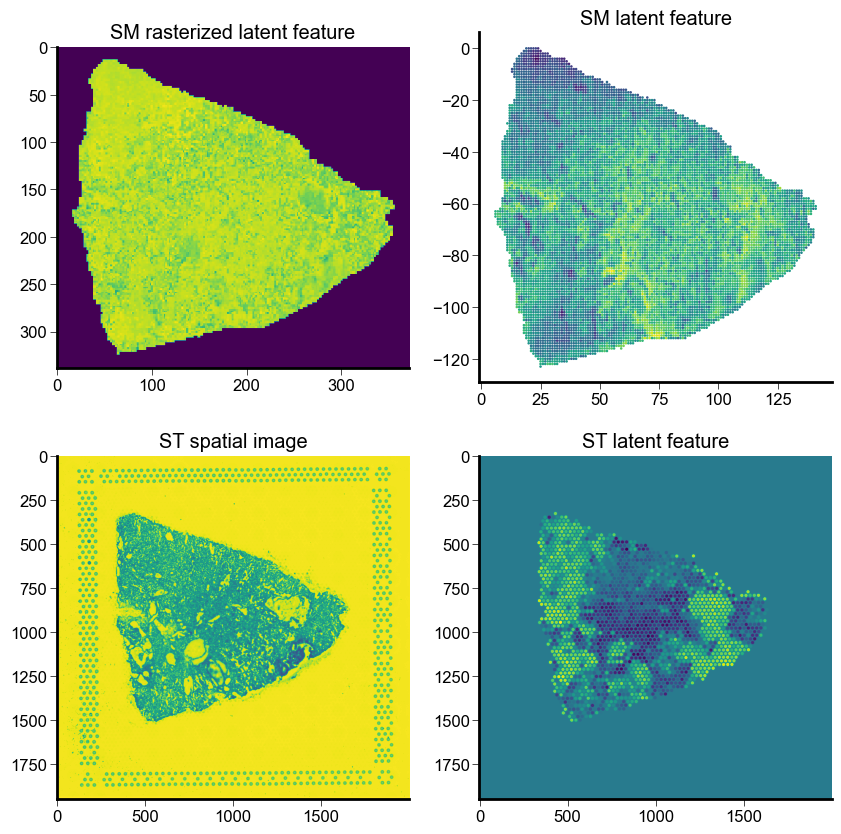

In [18]:
data = model.get_rasterized_feature_map()

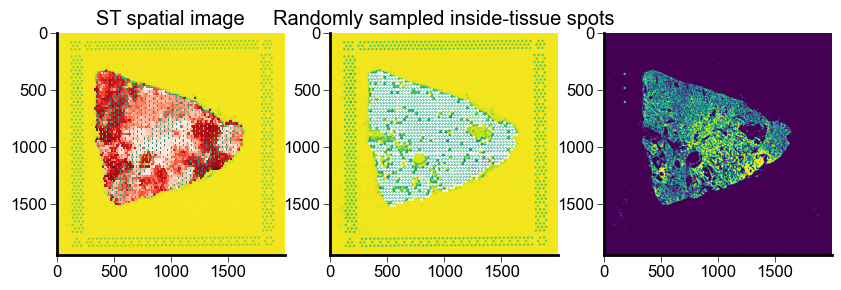

In [19]:
random_sample_inside_image_spot = model.random_sample_inside_image_spot(data)

The alignment results are evaluated using the `fit_alignment()` function, which calculates the alignment loss for different alignment configurations. The best alignment configuration is selected based on the lowest alignment loss. The aligned SM data is then saved to a new h5ad file using the `write_h5ad()` function.

In [20]:
result = model.fit_alignment(
    data,
    debug_path = './tmp/figures/point_alignment',
    align_st_feature = False
)

/home/rolan/Documents/spatialMETA/spatialmeta/model/_alignment_model.py:1096: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor([torch.log(torch.tensor(initial_scale)),torch.log(torch.tensor(initial_scale))], device=self.device, dtype=torch.float32, requires_grad=True)
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/rolan/Documents/spatialMETA/spatialmeta/model/_alignment_model.py:1130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

### Save and visualize the model results

In [21]:
best = list(result.keys())[np.argmin(np.array([result[x]['loss'][-1] for x in result.keys()]))]

In [22]:
adata_sm.obsm['spatial_transformed'] = result[best]['pointsIt']

Visualization of the alignment results

In [23]:
smt.pp.calculate_qc_metrics_sm(adata_sm)

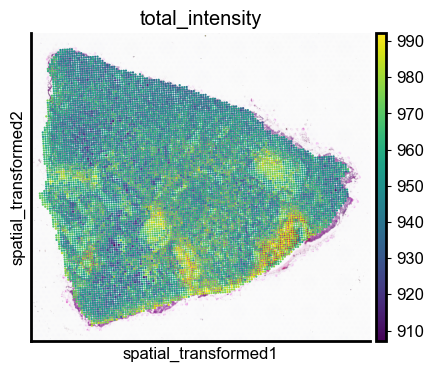

In [24]:
fig,ax=createFig()
sc.pl.spatial(adata_st, 
              show=False,
              ax=ax)
sc.pl.embedding(adata_sm,
                basis="spatial_transformed",
                ax=ax,
                s=10,
                color='total_intensity')

In [25]:
adata_sm.write_h5ad(sm_path.replace(".h5ad",".aligned.h5ad"))